# Notebook 2: Tree-Based Ensembles

In this notebook, we test tree-based algorithms using the original train/valid/test split. When possible, we try to leave the settings as default, in some cases we tweak the settings so that similar models have similar settings (e.g. sklearn/XGBoost/LightGBM random forests). 

These benchmarks are not definitive, hyperparameter tweaking and feature engineering could cause different models to perform better/worse, these are just baselines so we can narrow our searches.

In [1]:
# Global variables for testing changes to this notebook quickly
RANDOM_SEED = 0
NUM_FOLDS = 12

In [2]:
import numpy as np
import pandas as pd
import time
import os
import pyarrow
import gc

# Model evaluation
from sklearn.base import clone
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Models
from sklearn.utils.extmath import softmax
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


# Plotting
import matplotlib
import seaborn as sns
from matplotlib import pyplot as plt

# Hide warnings
import warnings
warnings.filterwarnings('ignore')

# Load and Prepare Data

In [3]:
def categorical_encoding(data):
    df = data.copy()
    df['Soil_Type'] = 0
    soil_features = list()
    for i in range(1,41):
        df['Soil_Type'] += i*df[f'Soil_Type{i}']
        soil_features.append(f'Soil_Type{i}')
    nonsoil_features = [x for x in df.columns if x not in soil_features]
    return df[nonsoil_features]

In [4]:
def get_data():
    try:
        #
        original = pd.read_feather('../data/original.feather')
    except:
        # Get Original Data
        original = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz', header = None)

        # Fix columns
        original.columns = ['Elevation', 'Aspect', 'Slope',
               'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
               'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
               'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
               'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
               'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
               'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
               'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
               'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
               'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
               'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
               'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
               'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
               'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
               'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
               'Cover_Type']

        for col, dtype in original.dtypes.iteritems():
            if dtype.name.startswith('int'):
                original[col] = pd.to_numeric(original[col], downcast ='integer')
            elif dtype.name.startswith('float'):
                original[col] = pd.to_numeric(original[col], downcast ='float')
        
        if not os.path.isdir('../data'):
            os.mkdir('../data')
        original.to_feather('../data/original.feather')
    return original

In [5]:
%%time
original = get_data()

# Get feature columns
original = categorical_encoding(original)
features = [x for x in original.columns if x not in ['Id','Cover_Type']]

# Encoder
old_encoder = LabelEncoder()
original["Cover_Type"] = old_encoder.fit_transform(original["Cover_Type"])

# Data structures for summary scores
metrics = list()

Wall time: 252 ms


# Scoring Function

In [6]:
def train_original(sklearn_model, plot = True):
    
    # Original Training/Test Split
    X_temp = original[features].iloc[:15119]
    X_test = original[features].iloc[15119:]
    y_temp = original['Cover_Type'].iloc[:15119]
    y_test = original['Cover_Type'].iloc[15119:]
    
    # Store the out-of-fold predictions
    test_preds = np.zeros((X_test.shape[0],7))
    scores = np.zeros(NUM_FOLDS)
    times = np.zeros(NUM_FOLDS)
    
    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits = NUM_FOLDS, shuffle = True, random_state = RANDOM_SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(X_temp,y_temp)):
       
        # Training and Validation Sets
        X_train = X_temp.iloc[train_idx]
        X_valid = X_temp.iloc[valid_idx]
        y_train = y_temp.iloc[train_idx]
        y_valid = y_temp.iloc[valid_idx]
        
        # Create model
        start = time.time()
        model = clone(sklearn_model)
        model.fit(X_train, y_train)

        # validation and test predictions
        valid_preds = np.ravel(model.predict(X_valid))
        test_preds += model.predict_proba(X_test)
        
        # fold auc score
        fold_acc = accuracy_score(y_valid, valid_preds)
        end = time.time()
        print(f'Fold {fold} Accuracy: {round(fold_acc, 5)} in {round(end-start,2)}s.')
        scores[fold] = fold_acc
        times[fold] = end-start
        time.sleep(0.5)
    
    test_preds = np.argmax(test_preds, axis = 1)
    holdout = accuracy_score(y_test, test_preds)
    print("\nAverage CV Accuracy:", round(scores.mean(), 5))
    print("Worst CV Accuracy:", round(scores.min(), 5))
    print('Holdout Accuracy:', round(holdout, 5))
    print(f'Training Time: {round(times.sum(), 2)}s\n')
    
    if plot:
        # Plot confusion matrix
        fig, ax = plt.subplots(figsize = (8,6))
        cm = confusion_matrix(y_test, test_preds, normalize = 'true')
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax = ax)
        plt.title("Confusion Matrix (% of Actual Labels)", fontsize=16)
        plt.xlabel("Predicted Labels", fontsize=14)
        plt.ylabel("Actual Labels", fontsize=14)
        plt.show()
    
    return scores.mean(), test_preds, holdout

# Scikit-Learn Models

We test the following models from the scikit-learn library:

1. AdaBoost
2. ExtraTrees
3. Bagging
4. RandomForest
5. GradientBoosting
6. HistGradientBoosting

## 1. AdaBoostClassifier

In [7]:
# AdaBoost Classifier
adaboost_pipeline = make_pipeline(
    AdaBoostClassifier(
        # Same settings as ExtraTreesClassifier
        base_estimator = DecisionTreeClassifier(
            splitter = 'random',
            random_state = RANDOM_SEED,
        ),
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.8 in 0.29s.
Fold 1 Accuracy: 0.81032 in 0.28s.
Fold 2 Accuracy: 0.78095 in 0.28s.
Fold 3 Accuracy: 0.78016 in 0.28s.
Fold 4 Accuracy: 0.77302 in 0.27s.
Fold 5 Accuracy: 0.76032 in 0.3s.
Fold 6 Accuracy: 0.78016 in 0.28s.
Fold 7 Accuracy: 0.78968 in 0.28s.
Fold 8 Accuracy: 0.77937 in 0.27s.
Fold 9 Accuracy: 0.80714 in 0.27s.
Fold 10 Accuracy: 0.78413 in 0.29s.
Fold 11 Accuracy: 0.78634 in 0.28s.

Average CV Accuracy: 0.78596
Worst CV Accuracy: 0.76032
Holdout Accuracy: 0.76229
Training Time: 3.37s



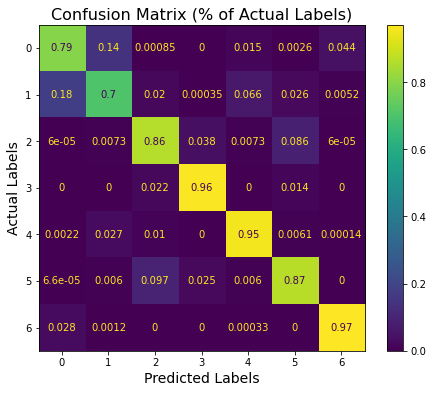

In [8]:
test_score, oof_preds, holdout = train_original(adaboost_pipeline)

metrics.append((
    'AdaBoost', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 2. ExtraTrees

In [9]:
# ExtraTrees Classifier
extratrees_pipeline = make_pipeline(
    ExtraTreesClassifier(
        n_jobs = -1,
        random_state = RANDOM_SEED,
        max_features = None,
    ),
)

Fold 0 Accuracy: 0.88968 in 2.87s.
Fold 1 Accuracy: 0.88175 in 2.94s.
Fold 2 Accuracy: 0.88571 in 2.9s.
Fold 3 Accuracy: 0.89127 in 2.98s.
Fold 4 Accuracy: 0.88968 in 2.89s.
Fold 5 Accuracy: 0.88492 in 2.9s.
Fold 6 Accuracy: 0.88095 in 2.94s.
Fold 7 Accuracy: 0.87222 in 2.82s.
Fold 8 Accuracy: 0.86349 in 2.86s.
Fold 9 Accuracy: 0.89286 in 2.89s.
Fold 10 Accuracy: 0.88968 in 2.84s.
Fold 11 Accuracy: 0.9023 in 2.84s.

Average CV Accuracy: 0.88538
Worst CV Accuracy: 0.86349
Holdout Accuracy: 0.78206
Training Time: 34.69s



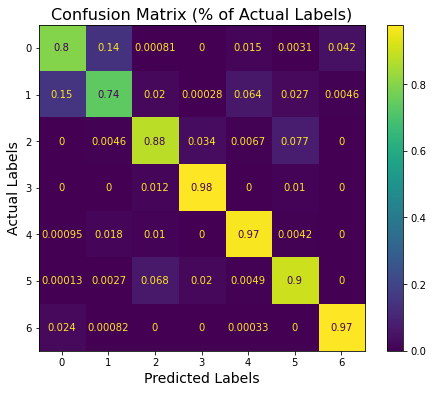

In [10]:
test_score, oof_preds, holdout = train_original(extratrees_pipeline)

metrics.append((
    'ExtraTrees', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 3. BaggingClassifier

In [11]:
# Bagging Classifier
bagging_pipeline = make_pipeline(
    BaggingClassifier(
        base_estimator = DecisionTreeClassifier(
            splitter = 'random',
            random_state = RANDOM_SEED,
        ),
        n_jobs = -1,
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.84841 in 3.59s.
Fold 1 Accuracy: 0.84206 in 1.6s.
Fold 2 Accuracy: 0.84127 in 1.63s.
Fold 3 Accuracy: 0.84603 in 1.63s.
Fold 4 Accuracy: 0.85317 in 1.62s.
Fold 5 Accuracy: 0.85635 in 1.63s.
Fold 6 Accuracy: 0.85159 in 1.59s.
Fold 7 Accuracy: 0.84365 in 1.63s.
Fold 8 Accuracy: 0.84683 in 1.6s.
Fold 9 Accuracy: 0.84444 in 1.62s.
Fold 10 Accuracy: 0.86746 in 1.64s.
Fold 11 Accuracy: 0.85941 in 1.61s.

Average CV Accuracy: 0.85006
Worst CV Accuracy: 0.84127
Holdout Accuracy: 0.75982
Training Time: 21.37s



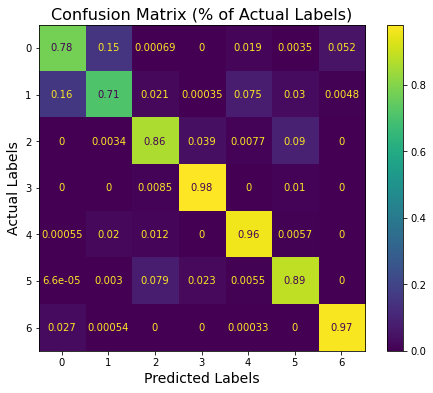

In [12]:
test_score, oof_preds, holdout = train_original(bagging_pipeline)

metrics.append((
    'Bagging', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 4. RandomForest

In [13]:
# Random Forest Classifier
randomforest_pipeline = make_pipeline(
    RandomForestClassifier(
        n_jobs = -1,
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.87302 in 2.97s.
Fold 1 Accuracy: 0.85873 in 2.86s.
Fold 2 Accuracy: 0.86429 in 2.94s.
Fold 3 Accuracy: 0.86746 in 2.96s.
Fold 4 Accuracy: 0.86746 in 2.83s.
Fold 5 Accuracy: 0.86587 in 2.84s.
Fold 6 Accuracy: 0.86667 in 2.84s.
Fold 7 Accuracy: 0.85556 in 2.91s.
Fold 8 Accuracy: 0.85159 in 2.84s.
Fold 9 Accuracy: 0.86825 in 2.8s.
Fold 10 Accuracy: 0.8627 in 2.78s.
Fold 11 Accuracy: 0.87292 in 2.9s.

Average CV Accuracy: 0.86454
Worst CV Accuracy: 0.85159
Holdout Accuracy: 0.74822
Training Time: 34.46s



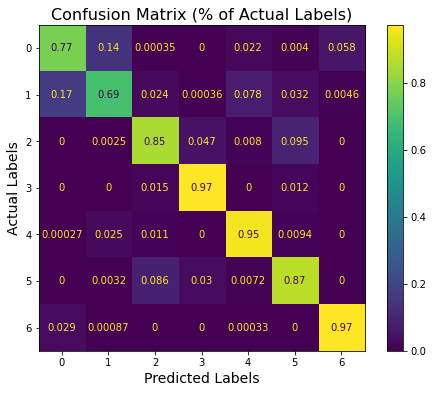

In [14]:
test_score, oof_preds, holdout = train_original(randomforest_pipeline)

metrics.append((
    'RandomForest', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 5. GradientBoosting

In [15]:
# Gradient Boosting Classifier
gbc_pipeline = make_pipeline(
    GradientBoostingClassifier(
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.79444 in 18.25s.
Fold 1 Accuracy: 0.78413 in 18.14s.
Fold 2 Accuracy: 0.79048 in 18.28s.
Fold 3 Accuracy: 0.79048 in 18.19s.
Fold 4 Accuracy: 0.8119 in 18.69s.
Fold 5 Accuracy: 0.79206 in 18.27s.
Fold 6 Accuracy: 0.80238 in 18.21s.
Fold 7 Accuracy: 0.79524 in 18.2s.
Fold 8 Accuracy: 0.79365 in 18.32s.
Fold 9 Accuracy: 0.80159 in 18.27s.
Fold 10 Accuracy: 0.80635 in 18.28s.
Fold 11 Accuracy: 0.80143 in 18.34s.

Average CV Accuracy: 0.79701
Worst CV Accuracy: 0.78413
Holdout Accuracy: 0.65137
Training Time: 219.44s



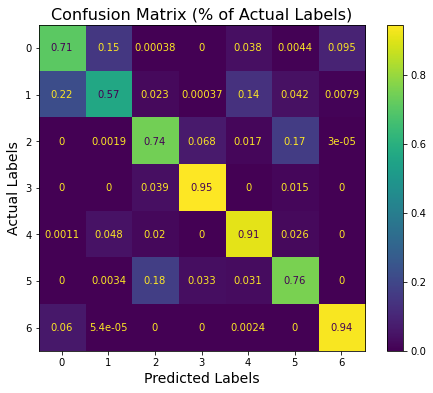

In [16]:
test_score, oof_preds, holdout = train_original(gbc_pipeline)

metrics.append((
    'GradientBoost', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 6. HistGradientBoosting

In [17]:
# Gradient Boosting Classifier
hgbc_pipeline = make_pipeline(
    HistGradientBoostingClassifier(
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.85714 in 8.36s.
Fold 1 Accuracy: 0.85794 in 8.93s.
Fold 2 Accuracy: 0.85714 in 8.67s.
Fold 3 Accuracy: 0.86111 in 8.92s.
Fold 4 Accuracy: 0.86667 in 8.83s.
Fold 5 Accuracy: 0.85238 in 8.86s.
Fold 6 Accuracy: 0.85 in 8.98s.
Fold 7 Accuracy: 0.85556 in 8.92s.
Fold 8 Accuracy: 0.85714 in 8.46s.
Fold 9 Accuracy: 0.86349 in 8.91s.
Fold 10 Accuracy: 0.85397 in 8.93s.
Fold 11 Accuracy: 0.8618 in 8.88s.

Average CV Accuracy: 0.85786
Worst CV Accuracy: 0.85
Holdout Accuracy: 0.74048
Training Time: 105.64s



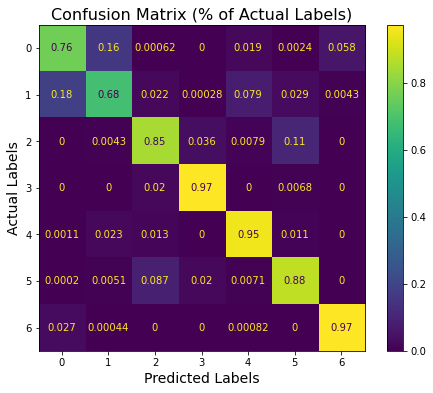

In [18]:
test_score, oof_preds, holdout = train_original(hgbc_pipeline)

metrics.append((
    'HistGradientBoost', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# XGBoost

We test out several XGBoost models:

1. Vanilla
2. Random Forest
3. DART

## 1. XGBoost Baseline

In [19]:
# XGBoost Classifier
xgb_pipeline = make_pipeline(
    XGBClassifier(
        booster = 'gbtree',
        tree_method = 'hist',
        eval_metric = 'mlogloss',
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.86349 in 1.71s.
Fold 1 Accuracy: 0.84762 in 1.76s.
Fold 2 Accuracy: 0.85079 in 1.75s.
Fold 3 Accuracy: 0.86349 in 1.83s.
Fold 4 Accuracy: 0.86349 in 1.75s.
Fold 5 Accuracy: 0.85714 in 1.7s.
Fold 6 Accuracy: 0.84762 in 1.7s.
Fold 7 Accuracy: 0.84921 in 1.75s.
Fold 8 Accuracy: 0.86032 in 1.71s.
Fold 9 Accuracy: 0.87381 in 1.72s.
Fold 10 Accuracy: 0.86667 in 1.71s.
Fold 11 Accuracy: 0.86497 in 1.72s.

Average CV Accuracy: 0.85905
Worst CV Accuracy: 0.84762
Holdout Accuracy: 0.74464
Training Time: 20.8s



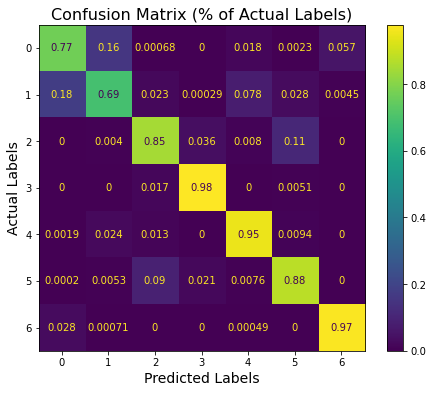

In [20]:
test_score, oof_preds, holdout = train_original(xgb_pipeline)

metrics.append((
    'XGBoost', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 2. XGBoost (Random Forest)

In [21]:
# XGBoost Classifier
xgbrf_pipeline = make_pipeline(
    XGBRFClassifier(
        tree_method = 'hist',
        eval_metric = 'mlogloss',
        num_parallel_tree = 100,
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.77063 in 1.95s.
Fold 1 Accuracy: 0.74444 in 2.0s.
Fold 2 Accuracy: 0.76032 in 2.01s.
Fold 3 Accuracy: 0.75476 in 2.02s.
Fold 4 Accuracy: 0.7746 in 2.03s.
Fold 5 Accuracy: 0.75556 in 2.04s.
Fold 6 Accuracy: 0.76746 in 1.99s.
Fold 7 Accuracy: 0.74921 in 2.05s.
Fold 8 Accuracy: 0.7619 in 2.08s.
Fold 9 Accuracy: 0.77302 in 2.1s.
Fold 10 Accuracy: 0.77063 in 2.03s.
Fold 11 Accuracy: 0.76092 in 2.02s.

Average CV Accuracy: 0.76196
Worst CV Accuracy: 0.74444
Holdout Accuracy: 0.58371
Training Time: 24.32s



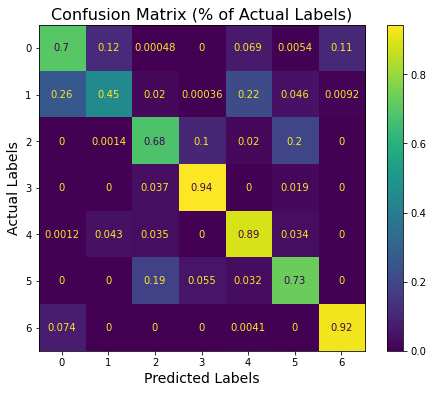

In [22]:
test_score, oof_preds, holdout = train_original(xgbrf_pipeline)

metrics.append((
    'XGBoost_RF', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 3. XGBoost (DART)

In [23]:
# XGBoost Classifier
xgbdart_pipeline = make_pipeline(
    XGBClassifier(
        booster = 'dart',
        tree_method = 'hist',
        eval_metric = 'mlogloss',
        rate_drop = 0.1,
        skip_drop = 0.5,
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.8381 in 6.04s.
Fold 1 Accuracy: 0.83175 in 6.1s.
Fold 2 Accuracy: 0.83175 in 6.09s.
Fold 3 Accuracy: 0.8381 in 6.01s.
Fold 4 Accuracy: 0.85794 in 5.96s.
Fold 5 Accuracy: 0.83968 in 5.96s.
Fold 6 Accuracy: 0.83651 in 5.96s.
Fold 7 Accuracy: 0.8373 in 6.04s.
Fold 8 Accuracy: 0.83492 in 6.02s.
Fold 9 Accuracy: 0.85 in 6.01s.
Fold 10 Accuracy: 0.84921 in 6.41s.
Fold 11 Accuracy: 0.8467 in 6.02s.

Average CV Accuracy: 0.841
Worst CV Accuracy: 0.83175
Holdout Accuracy: 0.71443
Training Time: 72.62s



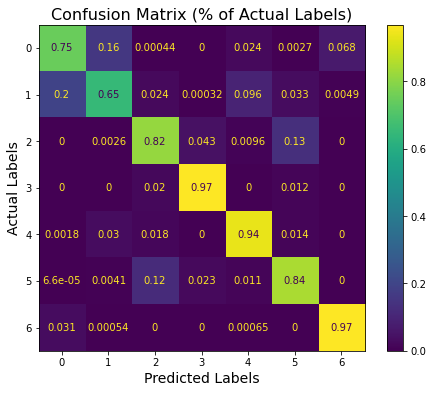

In [24]:
test_score, oof_preds, holdout = train_original(xgbdart_pipeline)

metrics.append((
    'XGBoost_DART', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# LightGBM

1. Vanilla
2. Random Forest
3. DART
4. GOSS

## 1. LightGBM (Baseline)

In [25]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        boosting_type = 'gbdt',
        metric = 'multi_logloss',
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.85635 in 3.06s.
Fold 1 Accuracy: 0.85 in 2.92s.
Fold 2 Accuracy: 0.85159 in 2.91s.
Fold 3 Accuracy: 0.8619 in 2.93s.
Fold 4 Accuracy: 0.87063 in 2.91s.
Fold 5 Accuracy: 0.85635 in 2.94s.
Fold 6 Accuracy: 0.85476 in 2.96s.
Fold 7 Accuracy: 0.85397 in 2.97s.
Fold 8 Accuracy: 0.85317 in 2.94s.
Fold 9 Accuracy: 0.8627 in 2.83s.
Fold 10 Accuracy: 0.86111 in 2.94s.
Fold 11 Accuracy: 0.85941 in 2.87s.

Average CV Accuracy: 0.85766
Worst CV Accuracy: 0.85
Holdout Accuracy: 0.73807
Training Time: 35.18s



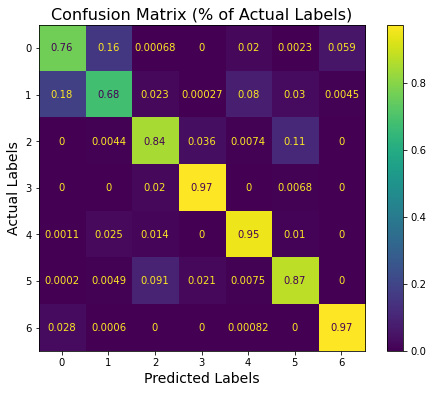

In [26]:
test_score, oof_preds, holdout = train_original(lgbm_pipeline)

metrics.append((
    'LightGBM', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 2. LightGBM (Random Forest)

In [27]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        boosting_type = 'rf',
        metric = 'multi_logloss',
        colsample_bynode = 0.8,
        subsample = 0.8,
        subsample_freq = 1,
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.7881 in 2.68s.
Fold 1 Accuracy: 0.75952 in 2.74s.
Fold 2 Accuracy: 0.77302 in 2.66s.
Fold 3 Accuracy: 0.77857 in 2.7s.
Fold 4 Accuracy: 0.79603 in 2.7s.
Fold 5 Accuracy: 0.78333 in 2.68s.
Fold 6 Accuracy: 0.7873 in 2.71s.
Fold 7 Accuracy: 0.77857 in 2.69s.
Fold 8 Accuracy: 0.78254 in 2.65s.
Fold 9 Accuracy: 0.79286 in 2.7s.
Fold 10 Accuracy: 0.8 in 2.67s.
Fold 11 Accuracy: 0.78872 in 2.65s.

Average CV Accuracy: 0.78405
Worst CV Accuracy: 0.75952
Holdout Accuracy: 0.62592
Training Time: 32.22s



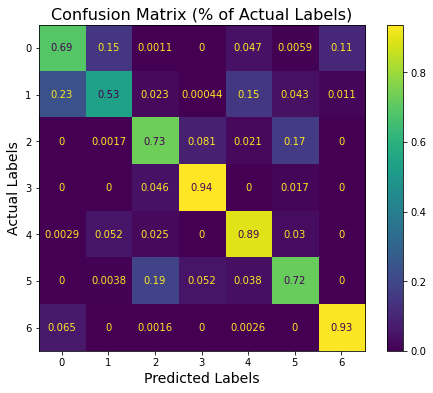

In [28]:
test_score, oof_preds, holdout = train_original(lgbm_pipeline)

metrics.append((
    'LightGBM_RF', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 3. LightGBM (DART)

In [29]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        boosting_type = 'dart',
        metric = 'multi_logloss',
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.8381 in 2.95s.
Fold 1 Accuracy: 0.83413 in 2.98s.
Fold 2 Accuracy: 0.84286 in 2.95s.
Fold 3 Accuracy: 0.83651 in 2.96s.
Fold 4 Accuracy: 0.85635 in 3.22s.
Fold 5 Accuracy: 0.84603 in 2.99s.
Fold 6 Accuracy: 0.84206 in 2.96s.
Fold 7 Accuracy: 0.83651 in 3.05s.
Fold 8 Accuracy: 0.82619 in 3.03s.
Fold 9 Accuracy: 0.84683 in 3.0s.
Fold 10 Accuracy: 0.84127 in 2.98s.
Fold 11 Accuracy: 0.85068 in 2.97s.

Average CV Accuracy: 0.84146
Worst CV Accuracy: 0.82619
Holdout Accuracy: 0.70406
Training Time: 36.05s



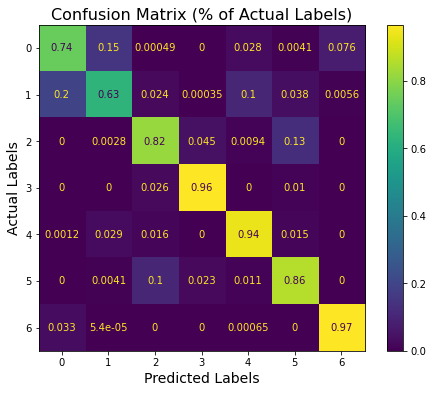

In [30]:
test_score, oof_preds, holdout = train_original(lgbm_pipeline)

metrics.append((
    'LightGBM_DART', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

## 4. LightGBM (GOSS)

In [31]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        boosting_type = 'goss',
        metric = 'multi_logloss',
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.85556 in 3.34s.
Fold 1 Accuracy: 0.84921 in 3.3s.
Fold 2 Accuracy: 0.85397 in 3.33s.
Fold 3 Accuracy: 0.87222 in 3.26s.
Fold 4 Accuracy: 0.8746 in 3.33s.
Fold 5 Accuracy: 0.84841 in 3.56s.
Fold 6 Accuracy: 0.86825 in 3.3s.
Fold 7 Accuracy: 0.85079 in 3.27s.
Fold 8 Accuracy: 0.83889 in 3.32s.
Fold 9 Accuracy: 0.87143 in 3.3s.
Fold 10 Accuracy: 0.85635 in 3.3s.
Fold 11 Accuracy: 0.86418 in 3.29s.

Average CV Accuracy: 0.85866
Worst CV Accuracy: 0.83889
Holdout Accuracy: 0.74069
Training Time: 39.9s



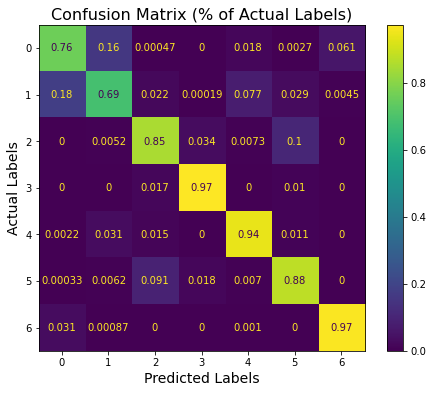

In [32]:
test_score, oof_preds, holdout = train_original(lgbm_pipeline)

metrics.append((
    'LightGBM_GOSS', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# LightGBM (ExtraTrees)

In [33]:
# LightGBM Classifier
lgbm_pipeline = make_pipeline(
    LGBMClassifier(
        extra_trees = True,
        metric = 'multi_logloss',
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.83016 in 3.46s.
Fold 1 Accuracy: 0.81032 in 3.46s.
Fold 2 Accuracy: 0.81825 in 3.5s.
Fold 3 Accuracy: 0.82619 in 3.55s.
Fold 4 Accuracy: 0.82857 in 3.52s.
Fold 5 Accuracy: 0.83413 in 3.49s.
Fold 6 Accuracy: 0.81508 in 3.52s.
Fold 7 Accuracy: 0.81349 in 3.53s.
Fold 8 Accuracy: 0.81825 in 3.58s.
Fold 9 Accuracy: 0.81746 in 3.51s.
Fold 10 Accuracy: 0.8381 in 3.55s.
Fold 11 Accuracy: 0.83479 in 3.6s.

Average CV Accuracy: 0.82373
Worst CV Accuracy: 0.81032
Holdout Accuracy: 0.70959
Training Time: 42.25s



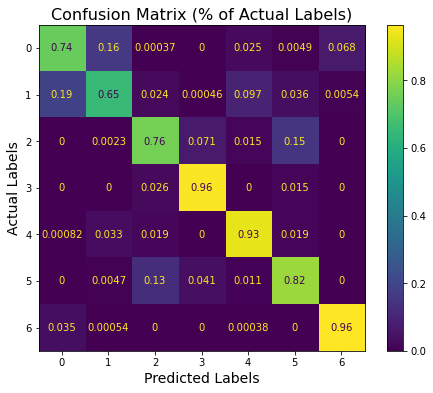

In [34]:
test_score, oof_preds, holdout = train_original(lgbm_pipeline)

metrics.append((
    'LightGBM_ExtraTrees', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# CatBoost

In [35]:
# LightGBM Classifier
catboost_pipeline = make_pipeline(
    CatBoostClassifier(
        eval_metric = 'MultiClass',
        verbose = False,
        random_state = RANDOM_SEED,
    ),
)

Fold 0 Accuracy: 0.85952 in 10.89s.
Fold 1 Accuracy: 0.85476 in 10.43s.
Fold 2 Accuracy: 0.85476 in 10.37s.
Fold 3 Accuracy: 0.86587 in 10.29s.
Fold 4 Accuracy: 0.87302 in 10.31s.
Fold 5 Accuracy: 0.85 in 10.38s.
Fold 6 Accuracy: 0.85079 in 10.36s.
Fold 7 Accuracy: 0.85556 in 10.43s.
Fold 8 Accuracy: 0.8381 in 10.31s.
Fold 9 Accuracy: 0.86905 in 10.25s.
Fold 10 Accuracy: 0.8619 in 10.27s.
Fold 11 Accuracy: 0.86338 in 10.29s.

Average CV Accuracy: 0.85806
Worst CV Accuracy: 0.8381
Holdout Accuracy: 0.73626
Training Time: 124.57s



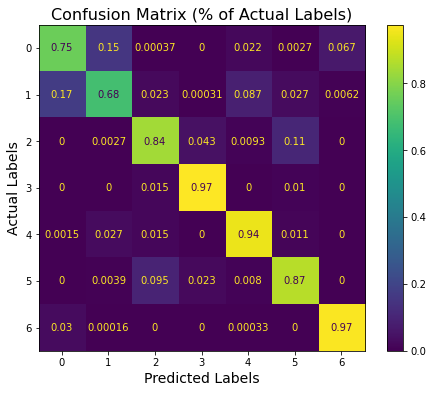

In [36]:
test_score, oof_preds, holdout = train_original(catboost_pipeline)

metrics.append((
    'CatBoost', test_score, holdout,
     *recall_score(original['Cover_Type'].iloc[15119:], oof_preds, average = None)
))

# Summary

In [37]:
pd.DataFrame.from_records(
    data = metrics,
    columns = ['model','accuracy','holdout','recall_0','recall_1','recall_2','recall_3','recall_4','recall_5','recall_6']
).sort_values('holdout')

,model,accuracy,holdout,recall_0,recall_1,recall_2,recall_3,recall_4,recall_5,recall_6
7,XGBoost_RF,0.761955,0.583708,0.698832,0.447733,0.680577,0.943782,0.887086,0.727757,0.922016
10,LightGBM_RF,0.784047,0.625919,0.688153,0.534579,0.730257,0.936968,0.889540,0.718945,0.930790
4,GradientBoost,0.797011,0.651367,0.708675,0.565905,0.744843,0.945486,0.906041,0.755770,0.937057
11,LightGBM_DART,0.841458,0.704061,0.742942,0.629506,0.816818,0.964225,0.938634,0.857566,0.966322
13,LightGBM_ExtraTrees,0.823732,0.709592,0.740800,0.651040,0.764340,0.959114,0.929224,0.817716,0.964469
8,XGBoost_DART,0.840995,0.714432,0.748440,0.647085,0.815806,0.967632,0.936043,0.844216,0.967847
14,CatBoost,0.858060,0.736261,0.754078,0.682245,0.839619,0.974446,0.944225,0.869731,0.969700
9,LightGBM,0.857663,0.738069,0.761389,0.679417,0.844352,0.972743,0.948861,0.874729,0.970627
5,HistGradientBoost,0.857861,0.740476,0.762882,0.682540,0.845394,0.972743,0.952407,0.880647,0.971717
12,LightGBM_GOSS,0.858655,0.740686,0.758723,0.686421,0.849025,0.972743,0.941497,0.877491,0.966594
